<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/325_metropolis.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>


(metropolis_notebook)=
# Monte Carlo a Catena di Markov

In precedenza, abbiamo esaminato diversi esempi di inferenza bayesiana riguardanti la distribuzione a posteriori di un singolo parametro, come nel caso del modello Bernoulliano. Abbiamo anche discusso l'utilizzo dell'approssimazione a griglia e dei metodi dei priori coniugati per ottenere o approssimare la distribuzione a posteriori. 

In questo capitolo, ci concentreremo sul metodo di simulazione e spiegheremo perché sono necessari metodi speciali chiamati metodi di Monte Carlo a Catena di Markov (MCMC).

In [19]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from scipy.stats import norm
from scipy.stats import binom
from scipy.stats import beta
import scipy.stats as st
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
import arviz as az

In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 12345
rng = np.random.default_rng(RANDOM_SEED)

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

sns.set_theme(palette="colorblind")

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Il denominatore bayesiano

Nel contesto del problema bayesiano, l'obiettivo principale è ottenere la distribuzione a posteriori di un parametro $\theta$, utilizzando i dati osservati $y$ e la distribuzione a priori $p(\theta)$. Questa distribuzione viene calcolata attraverso l'applicazione del teorema di Bayes:

$$
p(\theta \mid y) = \frac{p(y \mid \theta) p(\theta)}{p(y)}.
$$

Tuttavia, il calcolo dell'evidenza $p(y)$ può risultare complesso e non sempre possibile in modo analitico, soprattutto per modelli complessi, rendendo difficile ottenere la distribuzione a posteriori in modo esatto.

Le distribuzioni a priori coniugate offrono una via analitica per calcolare la distribuzione a posteriori, ma questa approccio limita le scelte del ricercatore a combinazioni specifiche di distribuzioni a priori e di verosimiglianza. Per modelli più complessi, in cui i metodi a griglia non sono applicabili, i Metodi di Monte Carlo a Catena di Markov (MCMC) costituiscono una potente alternativa per ottenere la distribuzione a posteriori. Questi metodi consentono di determinare la distribuzione basandosi su considerazioni teoriche, senza restrizioni sulla scelta delle distribuzioni a priori o di verosimiglianza.

Il metodo Monte Carlo utilizza opportune funzioni di numeri casuali per generare un ampio campione di osservazioni dalla distribuzione a posteriori. Le proprietà di interesse possono poi essere stimare empiricamente basandosi sul campione ottenuto.

In generale, il calcolo della distribuzione a posteriori in un problema bayesiano richiede l'uso di metodi computazionalmente intensivi, che possono essere eseguiti solo attraverso l'utilizzo di software. Tuttavia, grazie alla crescente potenza di calcolo dei computer negli ultimi anni, i metodi bayesiani di analisi dati sono diventati sempre più popolari, poiché tali calcoli sono ora accessibili a tutti.

## Metodo Monte Carlo 

Il metodo di Monte Carlo è una tecnica numerica che utilizza numeri casuali per ottenere soluzioni approssimate a problemi complessi, specialmente quando i calcoli analitici sono difficili o impossibili. L'idea alla base di questo metodo è di generare un ampio numero di punti casuali e utilizzarli per stimare quantità di interesse. Un esempio comune è l'integrazione numerica, dove integrali complessi vengono approssimati calcolando la media dei valori di una funzione in punti casuali generati all'interno di un dominio specifico.

Un esempio illustrativo può essere dato considerando la distribuzione continua $p(\theta \mid y)$ con media $\mu$. Se riusciamo a ottenere una sequenza di campioni casuali $\theta^{(1)}, \theta^{(2)},\dots, \theta^{(T)}$ indipendenti e identicamente distribuiti da $p(\theta \mid y)$, possiamo approssimare l'aspettazione teorica di $\theta$ con la media campionaria $\frac{1}{T} \sum_{i=1}^T \theta^{(t)}$. Questa approssimazione diventa sempre più precisa al crescere del numero di campioni $T$, grazie alla Legge Forte dei Grandi Numeri.

Inoltre, possiamo utilizzare il metodo di Monte Carlo per approssimare la probabilità che una variabile casuale $\theta$ cada all'interno di un intervallo specifico $(l, u)$. Questo può essere fatto calcolando la media campionaria del valore della funzione indicatrice $I(l < \theta < u)$ per ogni realizzazione $\theta^{(t)}$, ovvero $Pr(l < \theta < u) \approx \frac{\text{numero di realizzazioni } \theta^{(t)} \in (l, u)}{T}$.

Nell'analisi bayesiana, il metodo di Monte Carlo è utilizzato per ottenere un'approssimazione della distribuzione a posteriori $p(\theta \mid y)$, quando questa distribuzione non può essere calcolata tramite metodi analitici. In altre parole, il metodo di Monte Carlo ci consente di generare un gran numero di valori di $\theta$, che idealmente seguiranno la stessa distribuzione della distribuzione a posteriori $p(\theta \mid y)$.

In sintesi, il metodo di Monte Carlo è una potente tecnica numerica che si basa sulla generazione di numeri casuali per ottenere soluzioni approssimate in problemi complessi, consentendo di stimare aspettative e probabilità quando i calcoli analitici sono difficili o impossibili. L'accuratezza dell'approssimazione migliora al crescere del numero di campioni utilizzati. Nell'analisi bayesiana, il metodo di Monte Carlo è utilizzato per approssimare la distribuzione a posteriori.

## Campionamento dalla distribuzione a posteriori

Poniamoci ora il problema di approssimare la distribuzione a posteriori con una simulazione. Consideriamo nuovamente i dati di {cite:t}`zetsche_2019future` (ovvero, 23 "successi" in 30 prove Bernoulliane) e (arbitrariamente) assumiamo per $\theta$ una distribuzione a priori $Beta(2, 10)$. La distribuzione a posteriori in questo caso è $Beta(25, 17)$, come ottenuta analiticamente tramite lo schema beta-binomiale. Se vogliamo conoscere il valore della media a posteriori di $\theta$, il risultato esatto è

$$
\bar{\theta}_{post} = \frac{\alpha}{\alpha + \beta} = \frac{25}{25 + 17} \approx 0.5952.
$$

Usiamo ora una simulazione numerica per stimare la media a posteriori di $\theta$. Conoscendo la forma della distribuzione a posteriori $Beta(25, 17)$, possiamo generare un campione di osservazioni casuali da questa distribuzione. Successivamente, calcoliamo la media delle osservazioni ottenute per ottenere un'approssimazione della media a posteriori.

Se vogliamo ottenere un risultato approssimato con poche osservazioni (ad esempio, 10), possiamo procedere con la seguente simulazione:

In [13]:
y = beta(25, 17).rvs(10)
print(*y)


0.6105125470603144 0.5118485189088414 0.4607175974380624 0.6543877132129825 0.7891769159447564 0.5845169630214 0.625630883281281 0.6003336893924679 0.48992308506555954 0.601573883308274


In [14]:
y.mean()

0.5928621796633939

Tuttavia, con solo 10 campioni l'approssimazione potrebbe non essere molto accurata. Più aumentiamo il numero di campioni (cioè il numero di osservazioni casuali generate), più precisa sarà l'approssimazione. Aumentando il numero di campioni, ad esempio a 1000, otteniamo un risultato più preciso:

In [16]:
beta(25, 17).rvs(1000).mean()

0.5953898839987649

Quando il numero di campioni a posteriori è molto grande, la distribuzione campionaria *converge* alla densità della popolazione. Questo concetto vale non solo per la media, ma anche per altre statistiche descrittive come la moda e la varianza.

È importante notare che la simulazione di Monte Carlo funziona in modo efficace per il calcolo di distribuzioni a posteriori solo quando conosciamo la distribuzione a posteriori e possiamo utilizzare funzioni Python per estrarre campioni casuali da tale distribuzione, come nel caso della distribuzione a posteriori $Beta(25, 17)$. Tuttavia, questa situazione ideale non è sempre realizzabile in pratica poiché le distribuzioni a priori coniugate alla verosimiglianza sono spesso rare. Ad esempio, nel caso di una verosimiglianza binomiale e una distribuzione a priori gaussiana, 

$$
p(\theta \mid y) = \frac{\mathrm{e}^{-(\theta - 1 / 2)^2} \theta^y (1 - \theta)^{n - y}} {\int_0^1 \mathrm{e}^{-(t - 1 / 2)^2} t^y (1 - t)^{n - y} dt}.
$$

la distribuzione a posteriori di $\theta$ non può essere calcolata analiticamente e quindi non possiamo utilizzare direttamente Python per ottenere campioni casuali da essa.

In tali casi, è però possibile ottenere campioni casuali dalla distribuzione a posteriori utilizzando i metodi Monte Carlo basati su Catena di Markov (MCMC). Gli algoritmi MCMC, come l'algoritmo Metropolis, sono una classe di algoritmi che consentono di ottenere campioni casuali dalla distribuzione a posteriori *senza la necessità di conoscere la sua rappresentazione analitica*. Le tecniche MCMC sono ampiamente utilizzate per risolvere problemi di inferenza bayesiana e rappresentano il metodo computazionale più diffuso per ottenere stime approssimate di distribuzioni a posteriori in situazioni complesse e non analiticamente trattabili.

## L'algoritmo di Metropolis

Gli algoritmi MCMC sono utilizzati per campionare la distribuzione a posteriori mediante l'applicazione di un processo di catena di Markov. Questi algoritmi combinano tecniche di campionamento "Monte Carlo" e meccanismi di transizione "a salti" intelligenti, che non dipendono dalla posizione iniziale. Questo approccio consente di effettuare campionamenti "senza memoria" con salti intelligenti per evitare distorsioni sistematiche nei campioni generati.

Un esempio ben noto di algoritmo MCMC è l'algoritmo Metropolis, proposto per la prima volta da {cite:p}`metropolist_etal_1953` nel 1953. Questo algoritmo segue un semplice schema:

1. Si inizia l'algoritmo dalla posizione corrente nello spazio dei parametri.
2. Viene proposto un salto verso una nuova posizione nello spazio dei parametri.
3. Il salto viene accettato o rifiutato in modo probabilistico, basandosi sulle informazioni precedenti e sui dati disponibili.
4. Se il salto viene accettato, ci si sposta nella nuova posizione e si ritorna al passaggio 1.
5. Se il salto viene rifiutato, si rimane nella posizione attuale e si ritorna al passaggio 1.
6. Dopo aver effettuato un numero sufficiente di salti, si ottengono tutte le posizioni accettate come campioni dalla distribuzione a posteriori.

L'utilizzo di salti intelligenti e l'accettazione o il rifiuto probabilistico dei salti permettono all'algoritmo Metropolis e agli algoritmi MCMC in generale di esplorare lo spazio dei parametri in modo efficiente e fornire campioni rappresentativi della distribuzione a posteriori desiderata. 

In questo post (https://elevanth.org/blog/2017/11/28/build-a-better-markov-chain/), è possibile vedere una rappresentazione grafica del processo di "esplorazione" dello spazio dei parametri dell'algoritmo Metropolis. La principale differenza tra i vari algoritmi MCMC sta nel modo in cui vengono effettuati i salti e nel modo in cui viene presa la decisione se saltare o meno.

## Implementazione

Esaminiamo più in dettaglio l'algoritmo Metropolis.

- Iniziamo con un punto arbitrario $\theta^{(1)}$ nello spazio dei parametri. Questo primo valore della catena di Markov può essere scelto casualmente tra i valori possibili del parametro.
  
- Per ogni passo successivo $m + 1$ della catena estraiamo un valore candidato $\theta'$ da una distribuzione proposta $\Pi(\theta)$. Idealmente, la distribuzione proposta dovrebbe essere simile alla distribuzione a posteriori, ma in pratica, quando la distribuzione a posteriori è sconosciuta, possiamo estrarre casualmente $\theta'$ da una distribuzione simmetrica centrata sulla posizione corrente $\theta^{(m)}$. In questo esempio, useremo una distribuzione proposta gaussiana centrata sul valore corrente e con una deviazione standard appropriata: $\theta' \sim \mathcal{N}(\theta^{(m)}, \sigma)$. In pratica, questo significa che, se $\sigma$ è piccola, il valore candidato $\theta'$ sarà simile al valore corrente $\theta^{(m)}$.
  
- Calcoliamo il rapporto $r$ tra la densità a posteriori del parametro proposto $\theta'$ e la densità a posteriori del parametro corrente $\theta^{(m)}$. Utilizzando la regola di Bayes, il rapporto $r$ cancella la costante di normalizzazione e contiene solo le verosimiglianze e le distribuzioni a priori, entrambe facilmente calcolabili.

$$
r = \frac{p(\theta' \mid y)}{p(\theta^{(m)} \mid y)} = \frac{\frac{p(y \mid \theta') p(\theta')}{p(Y)}}{\frac{p(y \mid \theta^{(m)}) p(\theta^{(m)})}{p(Y)}} 
= \frac{p(y \mid \theta') p(\theta')}{p(y \mid \theta^{(m)}) p(\theta^{(m)})}.
$$ (eq-ratio-metropolis)

- Decidiamo se accettare o rigettare il candidato $\theta'$ in base al rapporto $r$. Se $r > 1$, il candidato è più credibile del valore corrente e viene sempre accettato. Altrimenti, accettiamo il candidato con probabilità $\min(r, 1)$, ovvero con una probabilità proporzionale al rapporto $r$. Ad esempio, se $r = 0.10$, la probabilità di accettare il candidato è del 10%. Questa strategia di scelta ci permette di ottenere un campione casuale dalla distribuzione a posteriori, poiché la probabilità di accettare il candidato è proporzionale alla sua densità nella distribuzione a posteriori. Implementiamo questa procedura confrontando il rapporto $r$ con un valore estratto casualmente da una distribuzione uniforme $Unif(0, 1)$. Se $r > u \sim Unif(0, 1)$, accettiamo il candidato $\theta'$ e la catena si sposta nella nuova posizione, ovvero $\theta^{(m+1)} = \theta'$. Altrimenti, $\theta^{(m+1)} = \theta^{(m)}$ e estraiamo un nuovo candidato dalla distribuzione proposta.
  
- Il passaggio finale calcola l'accettanza, cioè la proporzione di candidati $\theta'$ accettati come valori successivi della catena.

L'algoritmo Metropolis prende in input il numero $T$ di passi da simulare, la deviazione standard $\sigma$ della distribuzione proposta e la densità a priori, e restituisce come output la sequenza $\theta^{(1)}, \theta^{(2)}, \dots, \theta^{(T)}$. La chiave del successo dell'algoritmo Metropolis è il periodo in cui la catena approssima la stazionarietà. Tipicamente, i primi 1000-5000 elementi sono scartati perché rappresentano un periodo di "burn-in". Dopo un certo periodo $k$, la catena di Markov converge a una variabile casuale distribuita secondo la distribuzione a posteriori (stazionarietà). In altre parole, i campioni dal vettore $\left(\theta^{(k+1)}, \theta^{(k+2)}, \dots, \theta^{(T)}\right)$ diventano campioni di $p(\theta \mid y)$.

L'algoritmo descritto in questo capitolo è di {cite:t}`metropolist_etal_1953`. Un miglioramento di {cite:t}`hastings_1970` ha portato all'algoritmo Metropolis-Hastings. Il campionatore di Gibbs è dovuto a {cite}`geman_geman_1984`. L'approccio hamiltoniano Monte Carlo è dovuto a {cite:t}`duane1987hybrid` e il No-U-Turn Sampler (NUTS) è dovuto a {cite:t}`hoffman2014no`. Un'introduzione matematicamente intuitiva all'algoritmo Metropolis è data da {cite:t}`doing_bayesian_data_an`.

Implementiamo ora l'algoritmo Metropolis per trovare la distribuzione a posteriori di $\theta$ per i dati di {cite:t}`zetsche_2019future` (23 successi in 30 prove Bernoulliane), imponendo su $\theta$ una $Beta(2, 10)$. Nell'implementazione che verrà qui presentata, l'algoritmo Metropolis richiede l'uso delle seguenti funzioni.

**Verosimiglianza.** Useremo una funzione di verosimiglianza binomiale.

In [21]:
def get_likelihood(p):
    k = 23
    n = 30
    return binom.pmf(k, n, p)


**Distribuzione a priori.** In questo esempio, la distribuzione a priori è una distribuzione Beta con parametri 2 e 10, che viene scelta solo per motivi didattici e non ha alcuna motivazione ulteriore. 

In [22]:
def get_prior(p):
    a = 2
    b = 10
    return beta.pdf(p, a, b)


**Distribuzione a posteriori.** La distribuzione a posteriori è data dal prodotto della distribuzione a priori e della verosimiglianza. Si noti che, per il motivo spiegato prima, non è necessario normalizzare la distribuzione a posteriori.

In [23]:
def get_posterior(p):
    return get_likelihood(p) * get_prior(p)


**Distribuzione proposta.** Per implementare l'algoritmo Metropolis utilizzeremo una distribuzione proposta gaussiana con parametro $\sigma$ = 0.9. Il valore candidato sarà dunque un valore selezionato a caso da una gaussiana di parametri $\mu$ uguale al valore corrente nella catena e $\sigma = 0.2$. In questo esempio, la deviazione standard $\sigma$ è stata scelta empiricamente in modo tale da ottenere una accettanza adeguata. Nella funzione ho anche inserito un controllo che impone al valore candidato di essere incluso nell'intervallo \[0, 1\], com'è necessario per il valore di una proporzione.


In [24]:
def get_proposal(p_current, proposal_width):
    while 1:
        proposal = norm(p_current, proposal_width).rvs()
        if proposal > 0 and proposal < 1:
            break
    return proposal


L'algoritmo Metropolis viene implementato nella funzione seguente.

In [25]:
def sampler(samples=100, p_init=0.5, proposal_width=0.2):
    p_current = p_init
    posterior = [p_current]
    acceptance = 0
    for i in range(samples):
        # Suggest new position
        proposal = get_proposal(p_current, proposal_width)
        # Accept proposal?
        p_accept = get_posterior(proposal) / get_posterior(p_current)
        accept = np.random.rand() < p_accept
        if accept:
            # Update position
            p_current = proposal
            acceptance = acceptance + 1
        posterior.append(p_current)
    return acceptance / samples, np.array(posterior)


Utilizzo ora il campionatore `sampler()`, per generare una sequenza (catena) di valori $\theta$.

In [32]:
acceptance, posterior = sampler(samples=20000, p_init=0.5, proposal_width=0.2)

Esamino l'accettanza.

In [33]:
acceptance

0.4262

## Warm-up/Burn-in

Una catena di Markov ha bisogno di alcune iterazioni per raggiungere la distribuzione stazionaria. Queste iterazioni sono comunemente chiamate iterazioni di warm-up o burn-in (a seconda dell'algoritmo e del software utilizzato) e vengono di solito scartate. In molti programmi software, la prima metà delle iterazioni viene considerata come iterazioni di warm-up, quindi anche se abbiamo ottenuto 20000 iterazioni, ne verranno utilizzate solo 10000.

## La proprietà di ergodicità

Una catena di Markov descrive come una variabile transita da uno "stato" all'altro. Lo stato corrente dipende dallo stato precedente. Una catena di Markov ben definita è detta ergodica, il che significa che soddisfa le seguenti proprietà (vedi Hoff, 2009, capitolo 10):

1. *Irreversibile*: da qualsiasi stato θ(m), la catena può eventualmente raggiungere qualsiasi altro stato θ∗. Una catena riducibile, al contrario, contiene stati che non possono raggiungere alcuni altri stati; un esempio è quando la catena rimane costantemente positiva e non torna mai al lato negativo.
2. *Aperiodica*: la catena non ha stati periodici. Se fosse periodica, alcuni valori potrebbero essere visitati solo ogni k-esima iterazione.
3. *Ricorrente*: dopo aver visitato uno stato specifico θ∗, se la catena prosegue abbastanza a lungo, tornerà nuovamente nello stesso stato θ∗.

Sotto le condizioni sopra indicate, una catena di Markov converge verso una distribuzione stazionaria. Quindi, dopo un gran numero di iterazioni, i campioni estratti dalla catena possono essere considerati un campione casuale (ma correlato) della distribuzione stazionaria. Inoltre, è possibile dimostrare che con l'algoritmo Metropolis, la distribuzione stazionaria convergente è la distribuzione a posteriori (vedi la discussione in Kruschke, 2015, capitolo 7).

## Sintesi della distribuzione a posteriori

La lista `posterior` contiene 20000 valori di una catena di Markov. Escludiamo i primi 10000 valori considerati come burn-in e consideriamo i restanti 10000 valori come un campione casuale estratto dalla distribuzione a posteriori $p(\theta \mid y)$.

Mediante i valori della catena così ottenuta è facile trovare una stima a posteriori del parametro $\theta$. Per esempio, possiamo trovare la stima della media a posteriori.

In [35]:
np.mean(posterior[10001:20000])

0.5944953698273022

Oppure possiamo stimare la deviazione standard della distribuzione a posteriori.

In [36]:
np.std(posterior[10001:20000])

0.07362559142497607

Visualizziamo un *trace plot* dei valori della catena di Markov dopo il periodo di burn-in.

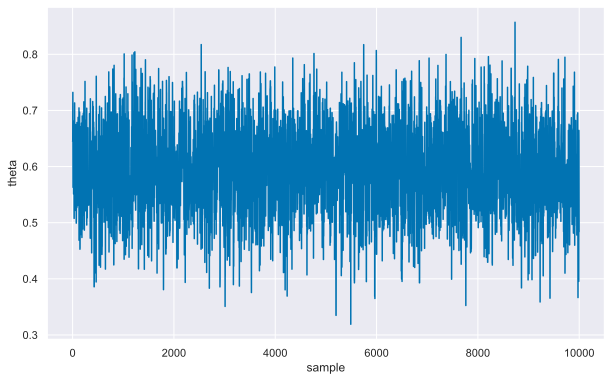

In [37]:
fig, ax = plt.subplots()
ax.plot(posterior[10001:20000])
_ = ax.set(xlabel="sample", ylabel="theta")


Il trace plot indica che la catena inizia con un valore casuale per poi spostarsi rapidamente nell'area intorno a 0.60, che è l'area con alta densità a posteriori. Successivamente, oscilla intorno a quel valore per le iterazioni successive.

Nella figura seguente, l'istogramma descrive i valori $\theta$ prodotti dall'algoritmo Metropolis mentre la linea continua descrive la distribuzione a posteriori ottenuta per via analitica, ovvero una $Beta(25, 17)$. La figura indica che la catena converge alla corretta distribuzione a posteriori.

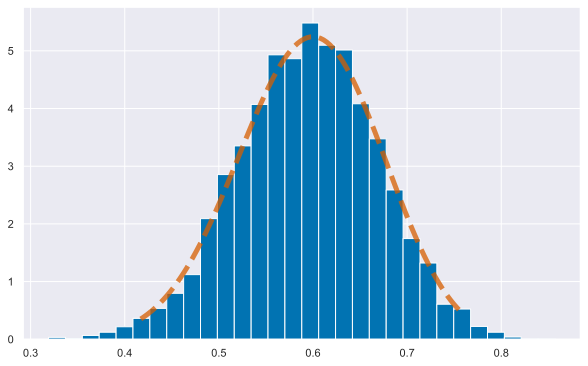

In [42]:
plt.hist(posterior[10001:20000], bins=30, label="estimated posterior", density=True)

a = 25
b = 17
x = np.linspace(st.beta.ppf(0.01, a, b), st.beta.ppf(0.99, a, b), 100)
_ = plt.plot(x, st.beta.pdf(x, a, b), "r--", lw=5, alpha=0.75, label="Beta(25, 17)")


È possibile usare la funzione `summary` di `arviz` per calolare l'intervallo di credibilità, ovvero l'intervallo che contiene la proporzione indicata dei valori estratti a caso dalla distribuzione a posteriori.

In [45]:
az.summary(posterior[10001:20000], kind="stats", hdi_prob=0.95, round_to=2)

,mean,sd,hdi_2.5%,hdi_97.5%
x,0.59,0.07,0.44,0.73


Un KDE plot corrispondente all'istogramma precedente si può generare usando `az.plot_posterior()`. La curva  rappresenta l'intera distribuzione a posteriori e viene calcolata utilizzando la stima della densità del kernel (KDE) che serve a "lisciare" l'istogramma.

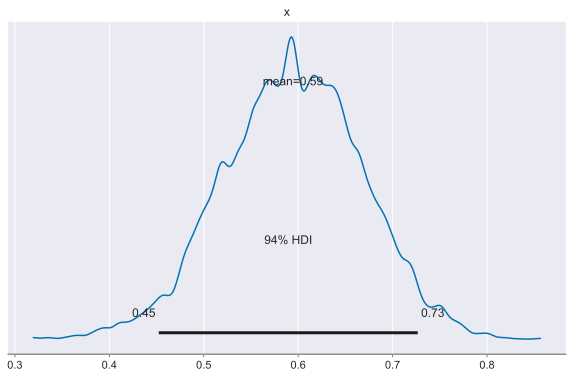

In [47]:
_ = az.plot_posterior(posterior[10001:20000])

L'HDI è una scelta comune nelle statistiche bayesiane e valori arrotondati come 50% o 95% sono molto popolari. Ma ArviZ utilizza il 94% come valore predefinito, come mostrato nella figura precedente. La ragione di questa scelta è che il 94% è vicino al valore ampiamente utilizzato del 95%, ma è anche diverso da questo, così da servire da "amichevole promemoria" che non c'è niente di speciale nella soglia del 5%. Idealmente sarebbe opportuno scegliere un valore che si adatti alle specifiche esigenze dell'analisi statistica che si sta svolgendo, o almeno riconoscere che si sta usando un valore arbitrario.

## Diagnostiche della soluzione MCMC

### Catene multiple

Poiché ciascuno stato in una catena di Markov dipende dagli stati precedenti, il valore o i valori iniziali possono influenzare i valori campionati. Una soluzione per verificare la sensibilità rispetto ai valori iniziali è utilizzare più catene, ognuna con diversi valori iniziali. Se più catene campionano la stessa distribuzione target, queste dovrebbero mescolarsi bene, ovvero intersecarsi l'una con l'altra in un trace plot.

### Stazionarietà

Un punto importante da verificare è se il campionatore ha raggiunto la sua distribuzione stazionaria. La convergenza di una catena di Markov alla distribuzione stazionaria viene detta "mixing".

#### Autocorrelazione

Ogni passo nell'algoritmo MCMC è chiamato *iterazione*. I valori campionati sono dipendenti, il che significa che il valore all'iterazione $m$ dipende dal valore all'iterazione $m-1$. Questa è una differenza importante rispetto alle funzioni che generano campioni casuali indipendenti, come `beta(25, 17).rvs()`. I valori campionati formano una *catena di Markov*, il che significa che ciascun valore campionato è correlato con il valore precedente (ad esempio, se $\theta(m)$ è grande, $\theta(m+1)$ sarà anch'esso grande).

Informazioni sul "mixing" della catena di Markov sono fornite dall'autocorrelazione. L'autocorrelazione misura la correlazione tra i valori successivi di una catena di Markov. Il valore $m$-esimo della serie ordinata viene confrontato con un altro valore ritardato di una quantità $k$ (dove $k$ è l'entità del ritardo) per verificare quanto si correli al variare di $k$. L'autocorrelazione di ordine 1 (*lag 1*) misura la correlazione tra valori successivi della catena di Markow (cioè, la correlazione tra $\theta^{(m)}$ e $\theta^{(m-1)}$); l'autocorrelazione di ordine 2 (*lag 2*) misura la correlazione tra valori della catena di Markow separati da due "passi" (cioè, la correlazione tra $\theta^{(m)}$ e $\theta^{(m-2)}$); e così via.

L'autocorrelazione di ordine $k$ è data da $\rho_k$ e può essere stimata come:

$$
\begin{align}
\rho_k &= \frac{Cov(\theta_m, \theta_{m+k})}{Var(\theta_m)}\notag\\
&= \frac{\sum_{m=1}^{n-k}(\theta_m - \bar{\theta})(\theta_{m-k} - \bar{\theta})}{\sum_{m=1}^{n-k}(\theta_m - \bar{\theta})^2} \qquad\text{con }\quad \bar{\theta} = \frac{1}{n}\sum_{m=1}^{n}\theta_m.
\end{align}
$$ (eq-autocor)

Per fare un esempio pratico, simuliamo dei dati autocorrelati.

In [21]:
x = pd.array([22, 24, 25, 25, 28, 29, 34, 37, 40, 44, 51, 48, 47, 50, 51])
print(*x)


22 24 25 25 28 29 34 37 40 44 51 48 47 50 51


L'autocorrelazione di ordine 1 è semplicemente la correlazione tra ciascun elemento e quello successivo nella sequenza.

In [22]:
sm.tsa.acf(x)

array([ 1.        ,  0.83174224,  0.65632458,  0.49105012,  0.27863962,
        0.03102625, -0.16527446, -0.30369928, -0.40095465, -0.45823389,
       -0.45047733, -0.36933174])

Nell'esempio, il vettore `x` è una sequenza temporale di 15 elementi. Il vettore $x'$ include gli elementi con gli indici da 0 a 13 nella sequenza originaria, mentre il vettore $x''$ include gli elementi 1:14. Gli elementi delle coppie ordinate dei due vettori avranno dunque gli indici $(0, 1)$, $(1, 2), (2, 3), \dots (13, 14)$ degli elementi della sequenza originaria. La correlazione di Pearson tra i vettori $x'$ e $x''$ corrisponde all'autocorrelazione di ordine 1 della serie temporale.

Nell'output precedente

-   0.83174224 è l'autocorrelazione di ordine 1 (lag = 1),
-   0.65632458 è l'autocorrelazione di ordine 2 (lag = 2),
-   0.49105012 è l'autocorrelazione di ordine 3 (lag = 3),
-   ecc.

È possibile specificare il numero di ritardi (*lag*) da utilizzare con l'argomento `nlags`:

In [23]:
sm.tsa.acf(x, nlags=4)

array([1.        , 0.83174224, 0.65632458, 0.49105012, 0.27863962])

In Python possiamo creare un grafico della funzione di autocorrelazione (correlogramma) per una serie temporale usando la funzione `tsaplots.plot_acf()` dalla libreria `statsmodels`.

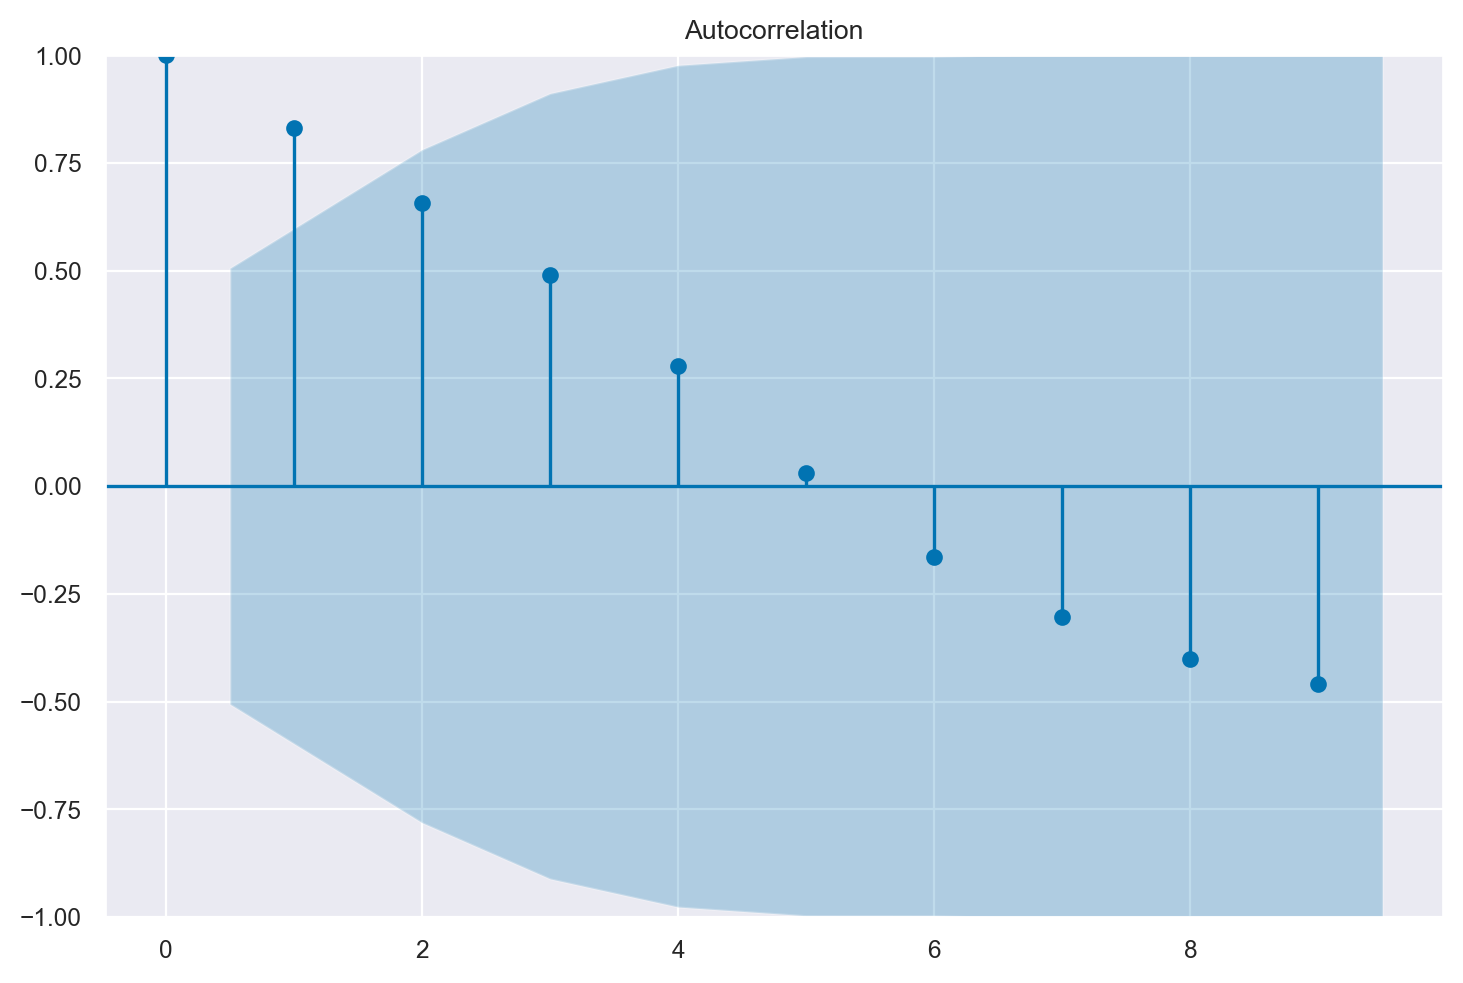

In [24]:
_ = tsaplots.plot_acf(x, lags=9)


Il correlogramma è uno strumento grafico usato per la valutazione della tendenza di una catena di Markov nel tempo. Il correlogramma si costruisce a partire dall'autocorrelazione $\rho_k$ di una catena di Markov in funzione del ritardo $k$ con cui l'autocorrelazione è calcolata: nel grafico ogni barretta verticale riporta il valore dell'autocorrelazione (sull'asse delle ordinate) in funzione del ritardo (sull'asse delle ascisse).

In situazioni ottimali l'autocorrelazione diminuisce rapidamente ed è effettivamente pari a 0 per piccoli lag. Ciò indica che i valori della catena di Markov che si trovano a più di soli pochi passi di distanza gli uni dagli altri non risultano associati tra loro, il che fornisce una conferma del "mixing" della catena di Markov, ossia della convergenza alla distribuzione stazionaria. Nelle analisi bayesiane, una delle strategie che consentono di ridurre l'autocorrelazione è quella di assottigliare l'output immagazzinando solo ogni $m$-esimo punto dopo il periodo di burn-in. Una tale strategia va sotto il nome di *thinning*.

### Accettanza

Quando si utilizza l'algoritmo Metropolis, è importante monitorare il tasso di accettazione e assicurarsi che sia nell'intervallo ottimale. Se si accetta quasi sempre il candidato proposto, probabilmente significa che, in ogni iterazione, la catena salta solo di un piccolo passo (in modo che il rapporto di accettazione sia vicino a 1 ogni volta). Di conseguenza, la catena impiegherà molte iterazioni per raggiungere altre regioni della distribuzione stazionaria e i campioni consecutivi saranno molto fortemente correlati. D'altra parte, se il tasso di accettazione è molto basso, la catena rimarrà bloccata nella stessa posizione per molte iterazioni prima di spostarsi verso uno stato diverso. Per l'algoritmo Metropolis base con un singolo parametro con una distribuzione proposta Gaussiana normale, un tasso di accettazione ottimale sarebbe compreso tra il 40% e il 50%.

### Test di convergenza

Un test di convergenza può essere svolto in maniera grafica mediante le tracce delle serie temporali (*trace plot*), cioè il grafico dei valori simulati rispetto al numero di iterazioni. Se la catena è in uno stato stazionario le tracce mostrano assenza di periodicità nel tempo e ampiezza costante, senza tendenze visibili o andamenti degni di nota. 

Ci sono inoltre alcuni test che permettono di verificare la stazionarietà del campionatore dopo un dato punto. Uno è il test di Geweke che suddivide il campione, dopo aver rimosso un periodo di burn in, in due parti. Se la catena è in uno stato stazionario, le medie dei due campioni dovrebbero essere uguali. Un test modificato, chiamato Geweke z-score, utilizza un test $z$ per confrontare i due subcampioni ed il risultante test statistico, se ad esempio è più alto di 2, indica che la media della serie sta ancora muovendosi da un punto ad un altro e quindi è necessario un periodo di burn-in più lungo.

### Effective sample size (ESS)

Quando le iterazioni sono dipendenti, ogni iterazione contiene informazioni sovrapposte con le iterazioni precedenti. In altre parole, quando si ottengono 500 campioni dipendenti dalla distribuzione a posteriori, questi contengono solo informazioni equivalenti a < 500 campioni indipendenti. L'ESS (Effective Sample Size) quantifica la quantità effettiva di informazioni, quindi una catena con ESS = n conterrà approssimativamente la stessa quantità di informazioni di n campioni indipendenti. In generale, vogliamo che l'ESS sia almeno 400 per un'utilizzazione generale nel riassumere la distribuzione a posteriori.

## Commenti e considerazioni finali 

In generale, la distribuzione a posteriori dei parametri di un modello statistico non può essere determinata per via analitica. Tale problema viene invece affrontato facendo ricorso ad una classe di algoritmi per il campionamento da distribuzioni di probabilità che sono estremamente onerosi dal punto di vista computazionale e che possono essere utilizzati nelle applicazioni pratiche solo grazie alla potenza di calcolo dei moderni computer. Lo sviluppo di software che rendono sempre più semplice l'uso dei metodi MCMC, insieme all'incremento della potenza di calcolo dei computer, ha contribuito a rendere sempre più popolare il metodo dell'inferenza bayesiana che, in questo modo, può essere estesa a problemi di qualunque grado di complessità.

## Watermark

In [25]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat May 06 2023

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.13.2

seaborn    : 0.12.2
scipy      : 1.10.1
matplotlib : 3.7.1
arviz      : 0.15.1
statsmodels: 0.14.0
pandas     : 1.5.3
numpy      : 1.23.5

Watermark: 2.3.1

